## Idea:
Predict the closing prices

In [2]:
import os
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
from typing import TypeVar, Callable, Sequence
from functools import reduce 
T=TypeVar('T')
from alpha_vantage.timeseries import TimeSeries 
import talib

%matplotlib inline
os.chdir(r'C:\Users\Aaditya Saini\Desktop\stock_price_prediction_model')

Initiating Pipeline....
Load Historical data NKE...


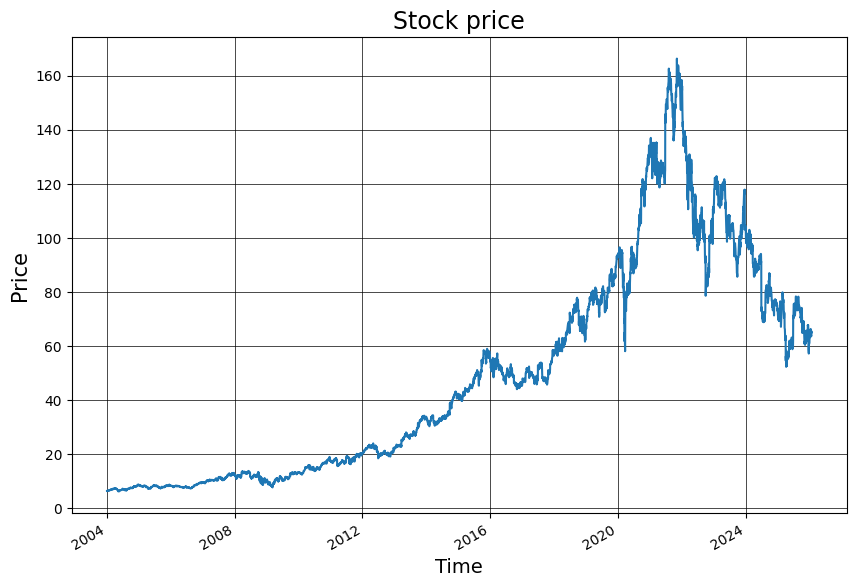


Feature extraction of technical indicators.
Bollinger Band
Lagged Price data
Simple moving average
Exponential moving average
Commodity channel index
Stochastic %K
Force index


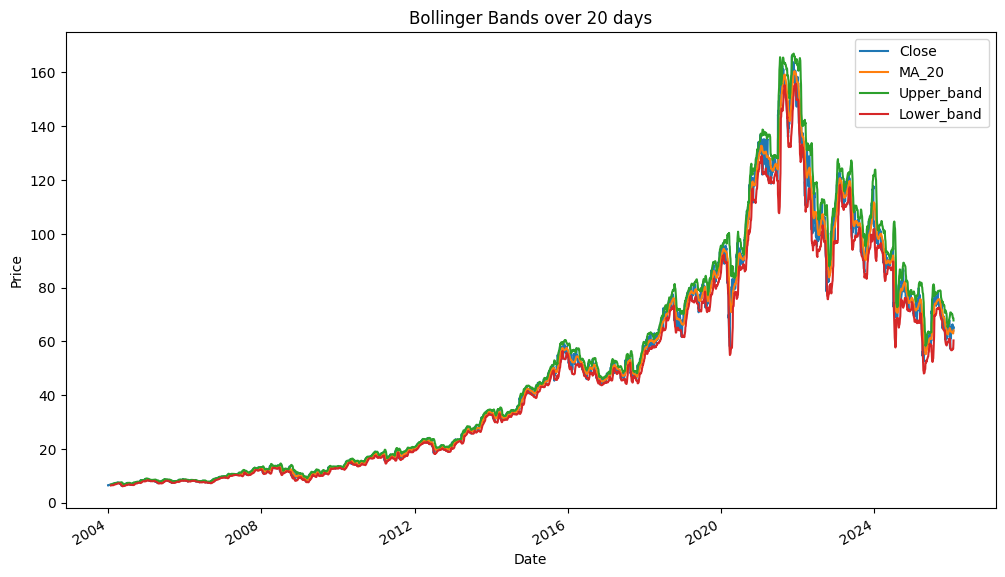

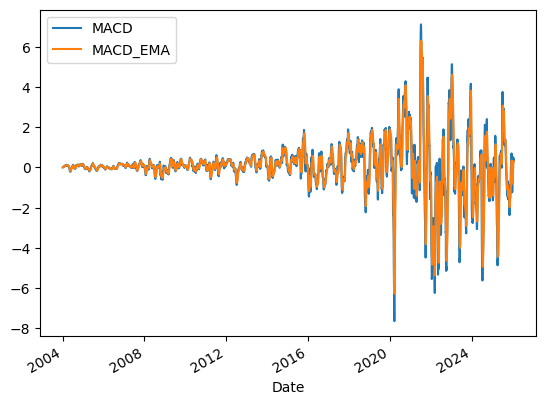


Extracting date features...
Extracting the dates

Fetching data for index funds
Fetching S&P 500...
Fetching DJIA...

Adding the future day close price as a target column for Forecast Horizon of 1
Saving extracted features data...
Extracted features shape - (5350, 62)

Extracted features dataframe:
                               Open      High       Low  Close(t)    Volume  \
Date                                                                          
2004-10-18 00:00:00-04:00  7.393378  7.622334  7.387654  7.622334  10456000   
2004-10-19 00:00:00-04:00  7.622334  7.697699  7.617564  7.657631  17851200   
2004-10-20 00:00:00-04:00  7.633786  7.682439  7.567961  7.598489   6701600   
2004-10-21 00:00:00-04:00  7.627109  7.746357  7.615662  7.707244  19664800   
2004-10-22 00:00:00-04:00  7.689116  7.712965  7.508813  7.546972  10804000   
2004-10-25 00:00:00-04:00  7.526940  7.658589  7.502136  7.624246   8943200   
2004-10-26 00:00:00-04:00  7.646187  7.774021  7.622337  7.706288  

In [3]:

import yfinance as yf

class Stocks:
    def __init__(self, ticker, start_date, forecast_horizon):
        self.ticker = ticker
        self.start_date = start_date
        self.forecast_horizon = forecast_horizon
    
    def get_stock_data(self, ticker):
        print(f"Load Historical data {self.ticker}...")
        
        # Use yfinance instead of Alpha Vantage
        stock = yf.Ticker(self.ticker)
        self.Stock = stock.history(start=self.start_date, end='2026-01-24')
        
        # Rename columns to match your code
        self.Stock = self.Stock.rename(columns={
            'Open': 'Open', 'High': 'High', 'Low': 'Low',
            'Close': 'Close', 'Volume': 'Volume'
        })
        
        # Keep only needed columns
        self.Stock = self.Stock[['Open', 'High', 'Low', 'Close', 'Volume']]
        
        self.Stock['Close'].plot(figsize=(10, 7))
        plt.title("Stock price", fontsize=17)
        plt.ylabel("Price", fontsize=15)
        plt.xlabel("Time", fontsize=14)
        plt.grid(which='major', color='k', linestyle='-', linewidth=0.5)
        plt.show()
        
        return ticker
    
    def extract_technical_indicators(self, ticker):
        print('\nFeature extraction of technical indicators.')
        
        # Bollinger Bands
        self.Stock['MA_20'] = self.Stock.Close.rolling(window=20).mean()
        self.Stock['SD_20'] = self.Stock.Close.rolling(window=20).std()
        self.Stock['Upper_band'] = self.Stock['MA_20'] + (self.Stock['SD_20'] * 2)
        self.Stock['Lower_band'] = self.Stock['MA_20'] - (self.Stock['SD_20'] * 2)
        print("Bollinger Band")
        
        # Lagged data
        for a in [1, 2, 3, 5]:
            self.Stock[f'S_close(t-{a})'] = self.Stock.Close.shift(periods=a)
            self.Stock[f'S_open(t-{a})'] = self.Stock.Open.shift(periods=a)
        print("Lagged Price data")
        
        # Simple Moving Average
        for w in [5, 10, 20, 50, 200]:
            self.Stock[f'MA{w}'] = self.Stock.Close.rolling(window=w).mean()
        print("Simple moving average")
        
        # Exponential Moving Average
        for w in [10, 20, 50, 100, 200]:
            self.Stock[f'EMA{w}'] = self.Stock.Close.ewm(span=w, adjust=False).mean().fillna(0)
        print("Exponential moving average")
        
        # MACD (moving average convergence and divergenece)
        self.Stock['EMA_12'] = self.Stock.Close.ewm(span=12, adjust=False).mean()
        self.Stock['EMA_26'] = self.Stock.Close.ewm(span=26, adjust=False).mean()
        self.Stock['MACD'] = self.Stock['EMA_12'] - self.Stock['EMA_26']
        self.Stock['MACD_EMA'] = self.Stock.MACD.ewm(span=9, adjust=False).mean()
        
        # Technical Indicators using TA-Lib
        self.Stock['ATR'] = talib.ATR(self.Stock['High'].values, self.Stock['Low'].values,
                                       self.Stock['Close'].values, timeperiod=14)
        self.Stock['ADX'] = talib.ADX(self.Stock['High'].values, self.Stock['Low'].values,
                                       self.Stock['Close'].values, timeperiod=14)
        
        # CCI
        tp = (self.Stock['High'] + self.Stock['Low'] + self.Stock['Close']) / 3
        ma = tp.rolling(window=20).mean()
        md = (tp - ma).rolling(window=20).mean().abs()
        self.Stock['CCI'] = (tp - ma) / (0.015 * md)
        print('Commodity channel index')
        
        # ROC
        self.Stock['ROC'] = ((self.Stock.Close - self.Stock.Close.shift(10)) / 
                             self.Stock.Close.shift(10)) * 100
        
        # RSI
        self.Stock['RSI'] = talib.RSI(self.Stock.Close.values, timeperiod=14)
        
        # Williams %R
        self.Stock['williams %R'] = talib.WILLR(self.Stock['High'].values, self.Stock['Low'].values,
                                                 self.Stock['Close'].values, timeperiod=14)
        
        # Stochastic %K
        self.Stock['So%k'] = ((self.Stock.Close - self.Stock.Low.rolling(window=14).min()) /
                              (self.Stock.High.rolling(window=14).max() - 
                               self.Stock.Low.rolling(window=14).min())) * 100
        print('Stochastic %K')
        
        # Standard deviation
        self.Stock['per_change'] = self.Stock.Close.pct_change()
        self.Stock['STD5'] = self.Stock.per_change.rolling(window=5).std()
        
        # Force Index
        self.Stock['Force_index1'] = self.Stock.Close.diff(1) * self.Stock.Volume
        self.Stock['Force_index20'] = self.Stock.Close.diff(20) * self.Stock.Volume
        print("Force index")
        
        # Plots
        self.Stock[['Close', 'MA_20', 'Upper_band', 'Lower_band']].plot(figsize=(12, 7))
        plt.title("Bollinger Bands over 20 days")
        plt.ylabel("Price")
        plt.show()
        
        self.Stock[['MACD', 'MACD_EMA']].plot()
        plt.show()
        
        self.Stock = self.Stock.drop(columns=['MA_20', 'per_change', 'EMA_12', 'EMA_26'])
        return ticker
    
    def extract_info(self, date_val):
        day = date_val.day
        dayofweek = date_val.dayofweek
        week = date_val.isocalendar().week
        dayofyear = date_val.dayofyear
        month = date_val.month
        is_month_end = date_val.is_month_end
        is_month_start = date_val.is_month_start
        is_quarter_end = date_val.is_quarter_end
        is_quarter_start = date_val.is_quarter_start
        is_year_end = date_val.is_year_end
        is_leap_year = date_val.is_leap_year
        year = date_val.year
        return day, dayofweek, week, dayofyear, month, is_month_end, is_month_start, \
               is_quarter_end, is_quarter_start, is_year_end, is_leap_year, year
    
    def extract_date_features(self, ticker):
        print('\nExtracting date features...')
        self.Stock['Date_col'] = self.Stock.index
        date_features = self.Stock.Date_col.apply(lambda date_val: pd.Series(self.extract_info(date_val)))
        date_features.columns = ['day', 'Dayofweek', 'week', 'Dayofyear', 'month', 
                                  'is_month_end', 'is_month_start', 'is_quarter_end',
                                  'is_quarter_start', 'is_year_end', 'is_leap_year', 'year']
        self.Stock = pd.concat([self.Stock, date_features], axis=1)
        print("Extracting the dates")
        return ticker
    
    def get_IDXFunds_features(self, ticker):
        print('\nFetching data for index funds')
        
        # QQQ
        QQQ = yf.Ticker('QQQ').history(start=self.start_date, end='2026-01-24')
        QQQ = QQQ[['Close']].copy()
        
        for a in [1, 2, 5]:
            QQQ[f'QQQ(t-{a})'] = QQQ.Close.shift(periods=a)
        for b in [10, 20, 50]:
            QQQ[f'QQQ_MA{b}'] = QQQ.Close.rolling(window=b).mean()
        
        QQQ = QQQ.drop(columns=['Close'])
        
        # S&P 500
        print('Fetching S&P 500...')
        SnP = yf.Ticker('SPY').history(start=self.start_date, end='2026-01-24')
        SnP = SnP[['Close']].copy()
        
        for c in [1, 5]:
            SnP[f'Snp(t-{c})'] = SnP.Close.shift(periods=c)
        
        SnP = SnP.drop(columns=['Close'])
        
        # DJIA
        print('Fetching DJIA...')
        DJIA = yf.Ticker('DIA').history(start=self.start_date, end='2026-01-24')
        DJIA = DJIA[['Close']].copy()
        
        for d in [1, 5]:
            DJIA[f'DJIA(t-{d})'] = DJIA.Close.shift(periods=d)
        
        DJIA = DJIA.drop(columns=['Close'])
        
        # Merge
        IDXFunds = QQQ.merge(SnP, left_index=True, right_index=True, how='inner')
        IDXFunds = IDXFunds.merge(DJIA, left_index=True, right_index=True, how='inner')
        self.Stock = self.Stock.merge(IDXFunds, left_index=True, right_index=True, how='inner')
        return ticker
    
    def forecast_Horizon(self, ticker):
        print(f'\nAdding the future day close price as a target column for Forecast Horizon of {self.forecast_horizon}')
        self.Stock['Close_forecast'] = self.Stock.Close.shift(-self.forecast_horizon)
        self.Stock = self.Stock.rename(columns={'Close': 'Close(t)'})
        self.Stock = self.Stock.dropna()
        return ticker
    
    def save_features(self, ticker):
        print('Saving extracted features data...')
        self.Stock.to_csv(self.ticker + '.csv')
        print(f'Extracted features shape - {self.Stock.shape}')
        print('\nExtracted features dataframe:')
        print(self.Stock.head(10))
        return self.Stock
    
    def pipeline(self, value, function_pipeline):
        return reduce(lambda v, f: f(v), function_pipeline, value)
    
    def pipeline_sequence(self):
        print('Initiating Pipeline....')
        z = self.pipeline(
            value=self.ticker,
            function_pipeline=(
                self.get_stock_data,
                self.extract_technical_indicators,
                self.extract_date_features,
                self.get_IDXFunds_features,
                self.forecast_Horizon,
                self.save_features
            )
        )

# Now you can use historical data from 2004!
features = Stocks('NKE', '2004-01-02', 1)

features.pipeline_sequence()

Initiating Pipeline....
Load Historical data IBM...


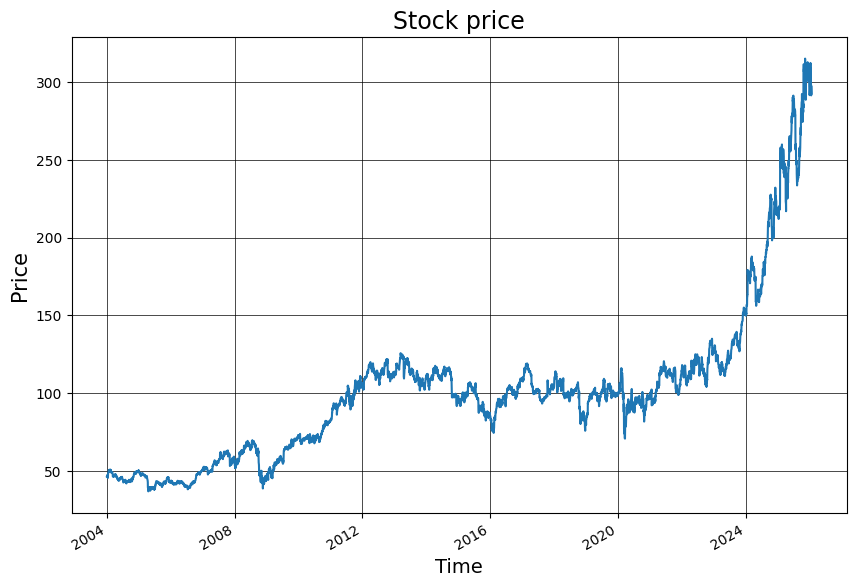


Feature extraction of technical indicators.
Bollinger Band
Lagged Price data
Simple moving average
Exponential moving average
Commodity channel index
Stochastic %K
Force index


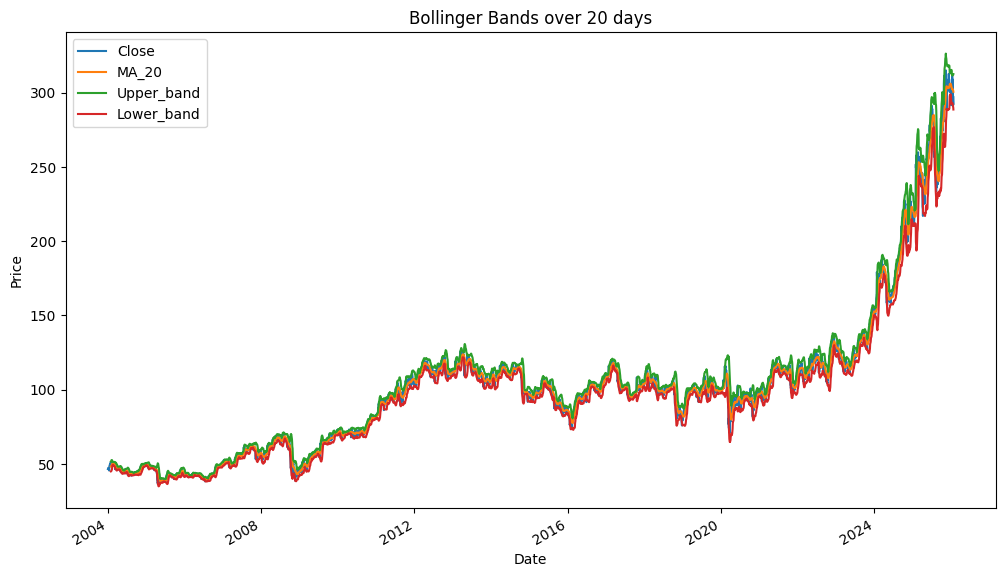

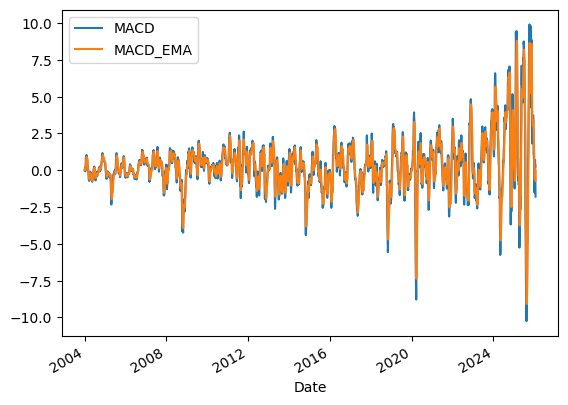


Extracting date features...
Extracting the dates

Fetching data for index funds
Fetching S&P 500...
Fetching DJIA...

Adding the future day close price as a target column for Forecast Horizon of 1
Saving extracted features data...
Extracted features shape - (5350, 62)

Extracted features dataframe:
                                Open       High        Low   Close(t)  \
Date                                                                    
2004-10-18 00:00:00-04:00  43.004263  43.948008  42.999162  43.830681   
2004-10-19 00:00:00-04:00  44.993774  45.774278  44.891749  45.590633   
2004-10-20 00:00:00-04:00  45.121309  45.498808  45.039688  45.310059   
2004-10-21 00:00:00-04:00  45.095811  45.279459  44.718311  44.942772   
2004-10-22 00:00:00-04:00  45.003998  45.121326  44.529571  44.580585   
2004-10-25 00:00:00-04:00  44.565281  45.350886  44.539771  45.111122   
2004-10-26 00:00:00-04:00  45.060105  45.692672  45.019297  45.401897   
2004-10-27 00:00:00-04:00  45.187632  46.0

In [4]:
features = Stocks('IBM', '2004-01-02', 1)

features.pipeline_sequence()

Initiating Pipeline....
Load Historical data KO...


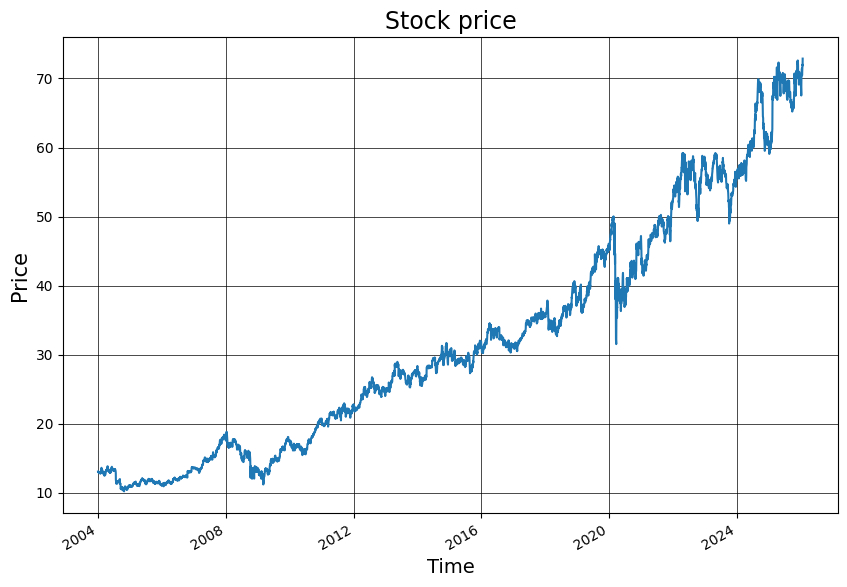


Feature extraction of technical indicators.
Bollinger Band
Lagged Price data
Simple moving average
Exponential moving average
Commodity channel index
Stochastic %K
Force index


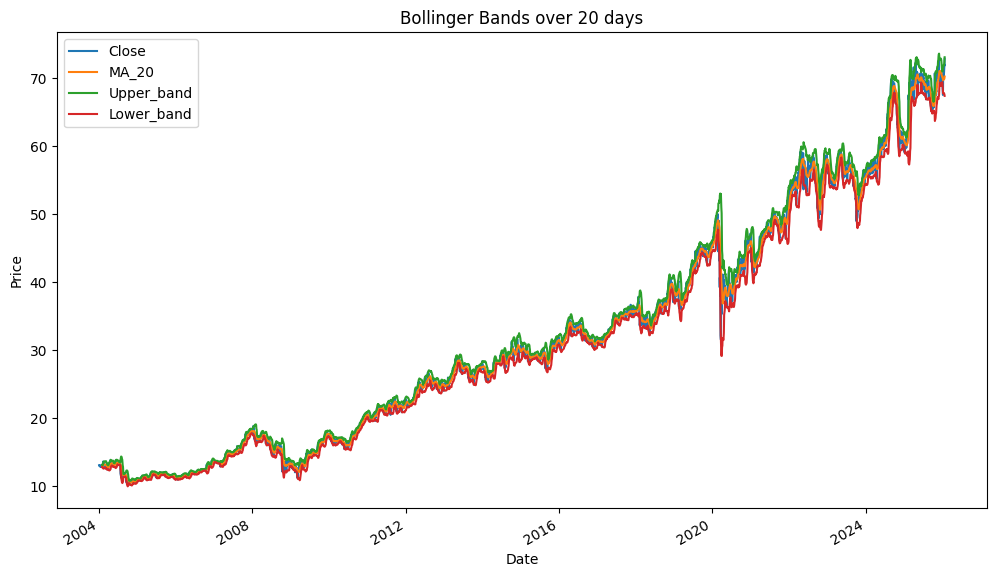

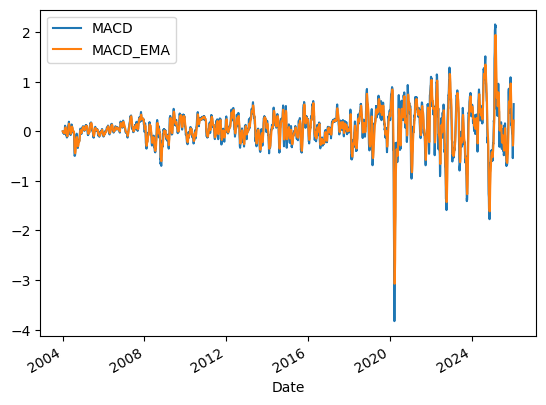


Extracting date features...
Extracting the dates

Fetching data for index funds
Fetching S&P 500...
Fetching DJIA...

Adding the future day close price as a target column for Forecast Horizon of 1
Saving extracted features data...
Extracted features shape - (5350, 62)

Extracted features dataframe:
                                Open       High        Low   Close(t)  \
Date                                                                    
2004-10-18 00:00:00-04:00  10.304401  10.362380  10.280682  10.341297   
2004-10-19 00:00:00-04:00  10.475704  10.475704  10.330758  10.378195   
2004-10-20 00:00:00-04:00  10.351839  10.409819  10.346569  10.396642   
2004-10-21 00:00:00-04:00  10.357112  10.415091  10.317582  10.404550   
2004-10-22 00:00:00-04:00  10.541589  10.607474  10.212164  10.251696   
2004-10-25 00:00:00-04:00  10.283322  10.285957  10.122563  10.185813   
2004-10-26 00:00:00-04:00  10.212167  10.409822  10.093574  10.357114   
2004-10-27 00:00:00-04:00  10.312311  10.6

In [5]:
features = Stocks('KO', '2004-01-02', 1)

features.pipeline_sequence()

Initiating Pipeline....
Load Historical data NVDA...


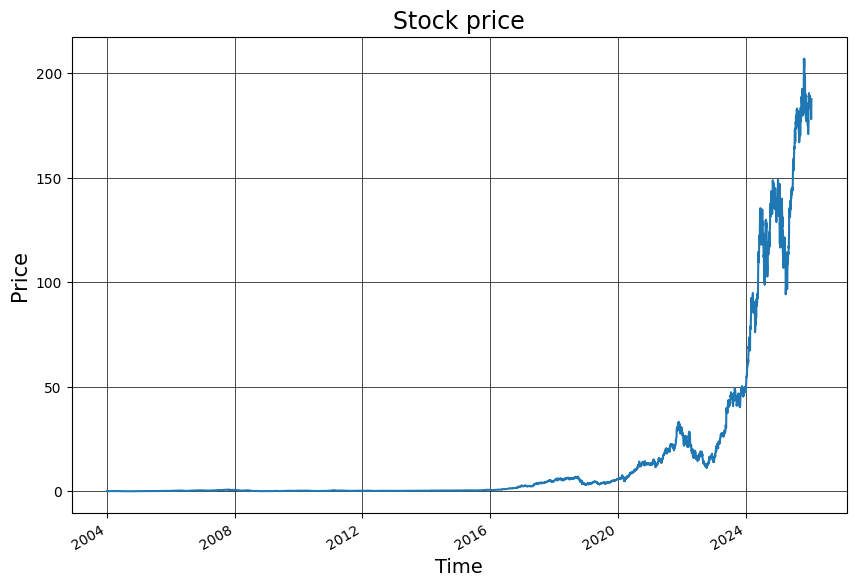


Feature extraction of technical indicators.
Bollinger Band
Lagged Price data
Simple moving average
Exponential moving average
Commodity channel index
Stochastic %K
Force index


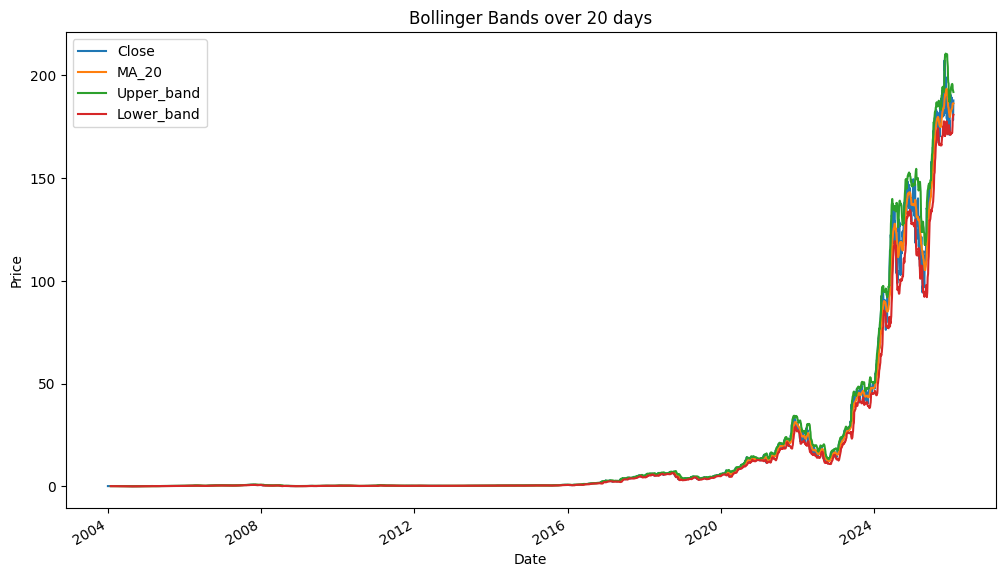

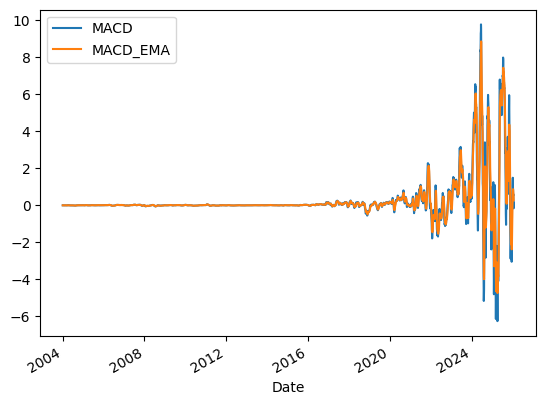


Extracting date features...
Extracting the dates

Fetching data for index funds
Fetching S&P 500...
Fetching DJIA...

Adding the future day close price as a target column for Forecast Horizon of 1
Saving extracted features data...
Extracted features shape - (5350, 62)

Extracted features dataframe:
                               Open      High       Low  Close(t)      Volume  \
Date                                                                            
2004-10-18 00:00:00-04:00  0.101922  0.105436  0.101081  0.104366   573972000   
2004-10-19 00:00:00-04:00  0.106735  0.107804  0.102915  0.103678   618480000   
2004-10-20 00:00:00-04:00  0.103373  0.105360  0.102762  0.104901   540204000   
2004-10-21 00:00:00-04:00  0.105970  0.108645  0.105131  0.107270  1013964000   
2004-10-22 00:00:00-04:00  0.108263  0.108492  0.101157  0.101463   686460000   
2004-10-25 00:00:00-04:00  0.100623  0.104137  0.100393  0.101922   529164000   
2004-10-26 00:00:00-04:00  0.111930  0.116056  0.10

In [6]:
features = Stocks('NVDA', '2004-01-02', 1)

features.pipeline_sequence()

Initiating Pipeline....
Load Historical data GS...


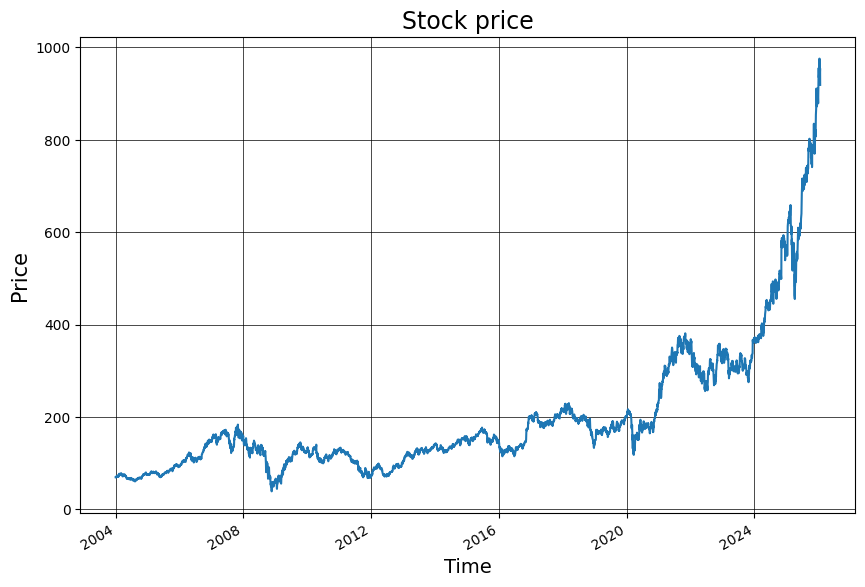


Feature extraction of technical indicators.
Bollinger Band
Lagged Price data
Simple moving average
Exponential moving average
Commodity channel index
Stochastic %K
Force index


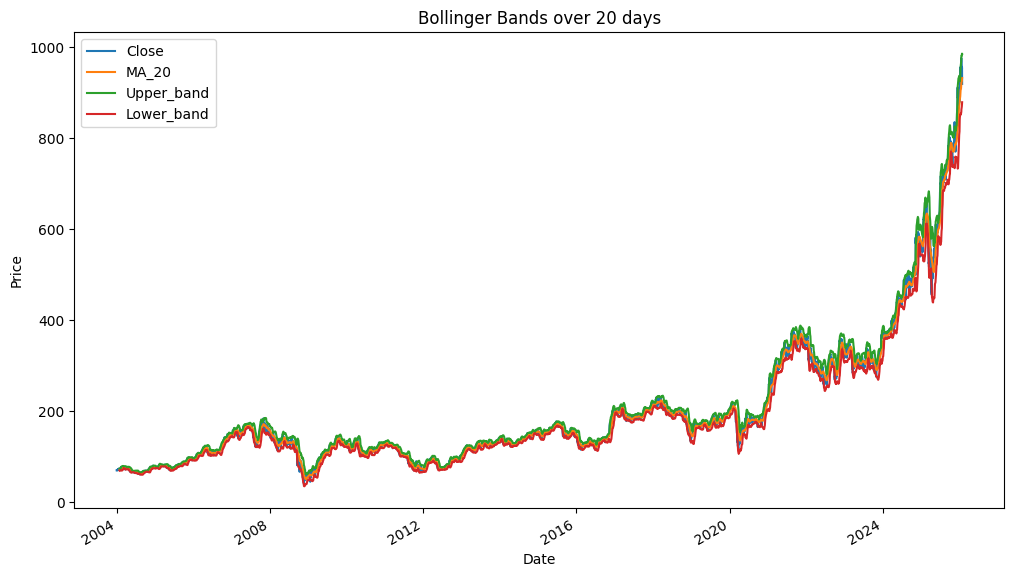

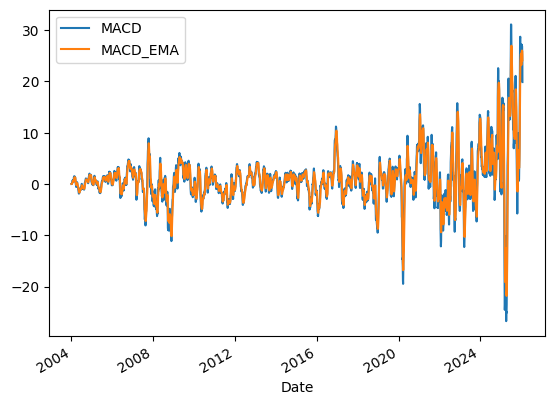


Extracting date features...
Extracting the dates

Fetching data for index funds
Fetching S&P 500...
Fetching DJIA...

Adding the future day close price as a target column for Forecast Horizon of 1
Saving extracted features data...
Extracted features shape - (5350, 62)

Extracted features dataframe:
                                Open       High        Low   Close(t)  \
Date                                                                    
2004-10-18 00:00:00-04:00  67.762108  67.970801  66.992079  67.826874   
2004-10-19 00:00:00-04:00  67.826850  68.366586  66.639429  66.970467   
2004-10-20 00:00:00-04:00  66.286808  66.704205  65.300888  66.452324   
2004-10-21 00:00:00-04:00  66.387380  67.722342  66.372950  67.448135   
2004-10-22 00:00:00-04:00  67.123391  67.642945  66.394577  66.892479   
2004-10-25 00:00:00-04:00  66.206958  66.899695  65.745133  66.690430   
2004-10-26 00:00:00-04:00  66.964657  68.393426  66.964657  67.657394   
2004-10-27 00:00:00-04:00  67.311015  69.4

In [7]:
features = Stocks('GS', '2004-01-02', 1)

features.pipeline_sequence()

Initiating Pipeline....
Load Historical data JNJ...


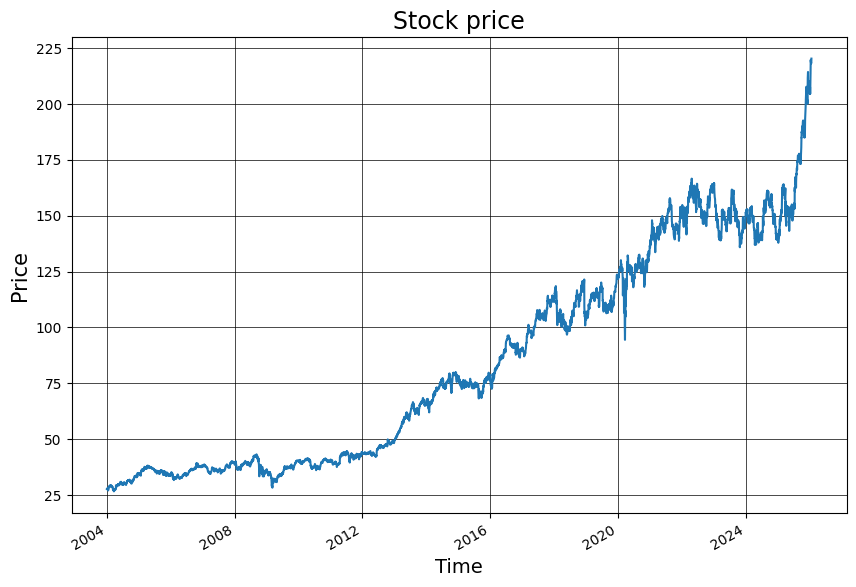


Feature extraction of technical indicators.
Bollinger Band
Lagged Price data
Simple moving average
Exponential moving average
Commodity channel index
Stochastic %K
Force index


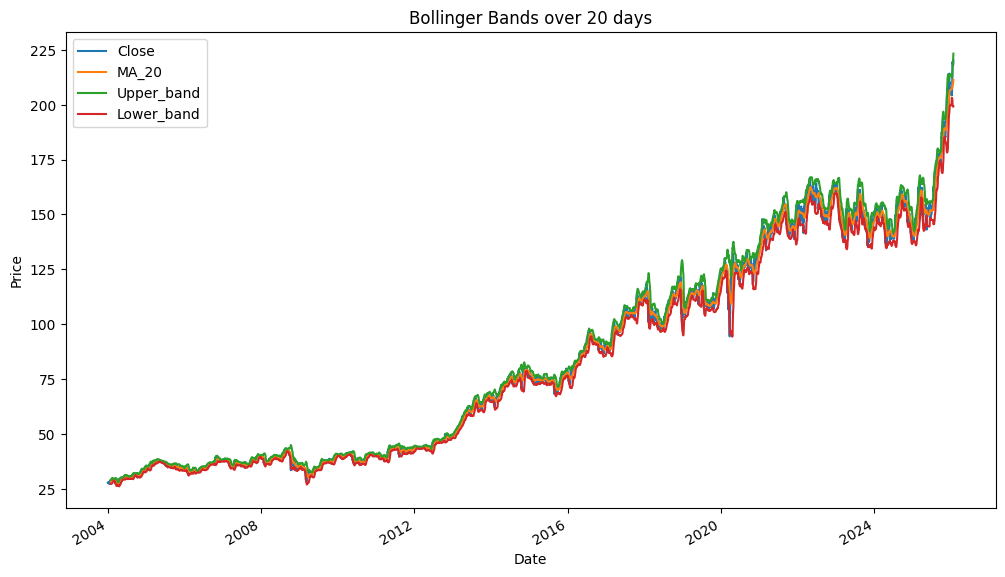

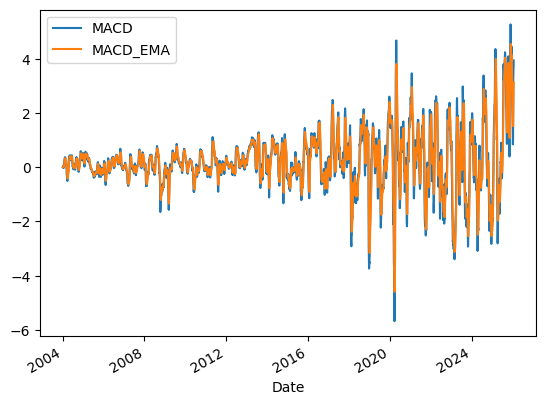


Extracting date features...
Extracting the dates

Fetching data for index funds
Fetching S&P 500...
Fetching DJIA...

Adding the future day close price as a target column for Forecast Horizon of 1
Saving extracted features data...
Extracted features shape - (5350, 62)

Extracted features dataframe:
                                Open       High        Low   Close(t)  \
Date                                                                    
2004-10-18 00:00:00-04:00  30.709174  31.403136  30.709174  31.321171   
2004-10-19 00:00:00-04:00  31.058898  31.375824  30.856720  30.933220   
2004-10-20 00:00:00-04:00  30.791134  31.419525  30.780207  31.419525   
2004-10-21 00:00:00-04:00  31.310241  31.670882  31.244670  31.572525   
2004-10-22 00:00:00-04:00  31.572515  31.687266  31.277447  31.304768   
2004-10-25 00:00:00-04:00  31.200977  31.315728  31.119014  31.190050   
2004-10-26 00:00:00-04:00  31.151777  31.332099  30.982386  31.271992   
2004-10-27 00:00:00-04:00  31.140848  31.5

In [8]:
features = Stocks('JNJ', '2004-01-02', 1)

features.pipeline_sequence()